# Feature Engineering and Exploratory Analysis

## Importing Data

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in CSV files
credit_df = pd.read_csv('data/credit_record.csv')
app_df = pd.read_csv('data/application_record.csv')

In [3]:
# Show info for credit_record
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [4]:
# Show application_record info
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

**Note!** Presence of null values in `OCCUPATION_TYPE`

## Feature Engineering

`application_record.csv` contains application data from customers. Features include personal identifying info, demographic data, basic financial data. `credit_record.csv` contains loan histories for a subset of customers. \
This dataset is unique in that it is incumbent on our team to flag high-risk credit card applicants. In other words, we need to define the target variable.

In [5]:
# Preview credit_df
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Per the dataset's documentation:
* **0**: 1-29 days past due
* **1**: 30-59 days past due
* **2**: 60-89 days overdue
* **3**: 90-119 days overdue
* **4**: 120-149 days overdue
* **5**: Overdue or bad debts, write-offs for more than 150 days
* **C**: paid off that month
* **X**: No loan for the month

In [6]:
# Add a new column that maps `STATUS` to numeric values
credit_df['STATUS_NUM'] = credit_df['STATUS'].map({
    'X':0,
    'C':0,
    '0':1,
    '1':2,
    '2':3,
    '3':4,
    '4':5,
    '5':6})

# Drop original STATUS column
credit_df = credit_df.drop(columns={'STATUS'})

credit_df.head()

,ID,MONTHS_BALANCE,STATUS_NUM
0,5001711,0,0
1,5001711,-1,1
2,5001711,-2,1
3,5001711,-3,1
4,5001712,0,0


Accounts that are 60+ days past due will be considered delinquent.

In [7]:
# Add Delinquent column. If Status_Num > 1, add 1 to column. Otherwise, 0.
credit_df['DELINQUENT'] = credit_df['STATUS_NUM'].apply(lambda x: 1 if x > 1 else 0)

In [8]:
# Check dataframe
credit_df[credit_df['STATUS_NUM'] > 1].head()

,ID,MONTHS_BALANCE,STATUS_NUM,DELINQUENT
150,5001718,-8,2,1
154,5001718,-12,2,1
224,5001720,0,2,1
227,5001720,-3,2,1
228,5001720,-4,2,1


In [9]:
# Group by ID, then get the earliest month. Rename column. Make this into a DF for merging
earliest = pd.DataFrame(credit_df.groupby(['ID'])['MONTHS_BALANCE'].min()).reset_index()
earliest = earliest.rename(columns={'MONTHS_BALANCE':'FIRST_MONTH'})
earliest.head()

,ID,FIRST_MONTH
0,5001711,-3
1,5001712,-18
2,5001713,-21
3,5001714,-14
4,5001715,-59


In [10]:
# Get every customer's last month in the dataset
last_month = pd.DataFrame(credit_df.groupby('ID')['MONTHS_BALANCE'].max()).reset_index()
last_month = last_month.rename(columns={'MONTHS_BALANCE':'FINAL_MONTH'})
last_month.head()

,ID,FINAL_MONTH
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [11]:
# Get total number of months of activity for every customer
customer_count = pd.DataFrame(credit_df.groupby('ID')['STATUS_NUM'].count()).reset_index()
customer_count = customer_count.rename(columns={'STATUS_NUM':'NUM_OF_MONTHS'})
customer_count.head()

,ID,NUM_OF_MONTHS
0,5001711,4
1,5001712,19
2,5001713,22
3,5001714,15
4,5001715,60


In [12]:
# Get sum of delinquent months from dlq_df
dlq_count = pd.DataFrame(credit_df.groupby('ID')['DELINQUENT'].sum()).reset_index()
dlq_count = dlq_count.rename(columns={'DELINQUENT':'NUM_OF_DLQ_MONTHS'})
dlq_count.head()

,ID,NUM_OF_DLQ_MONTHS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [13]:
# Merge dataframes into new df. Reorder columns
customer_sum = earliest.merge(last_month, on='ID', how='left')
customer_sum = customer_sum.merge(dlq_count, on='ID', how='left')
customer_sum = customer_sum.merge(customer_count, on='ID', how='left')
customer_sum = customer_sum[['ID','FIRST_MONTH','FINAL_MONTH','NUM_OF_MONTHS','NUM_OF_DLQ_MONTHS']]

In [14]:
# Preview dataframe
customer_sum.head()

,ID,FIRST_MONTH,FINAL_MONTH,NUM_OF_MONTHS,NUM_OF_DLQ_MONTHS
0,5001711,-3,0,4,0
1,5001712,-18,0,19,0
2,5001713,-21,0,22,0
3,5001714,-14,0,15,0
4,5001715,-59,0,60,0


In [15]:
# Calculate delinquency percentage
customer_sum['DLQ_PERCENT'] = customer_sum['NUM_OF_DLQ_MONTHS'] / customer_sum['NUM_OF_MONTHS']

# Fill NaN (div/0) with 0
customer_sum = customer_sum.fillna(0)

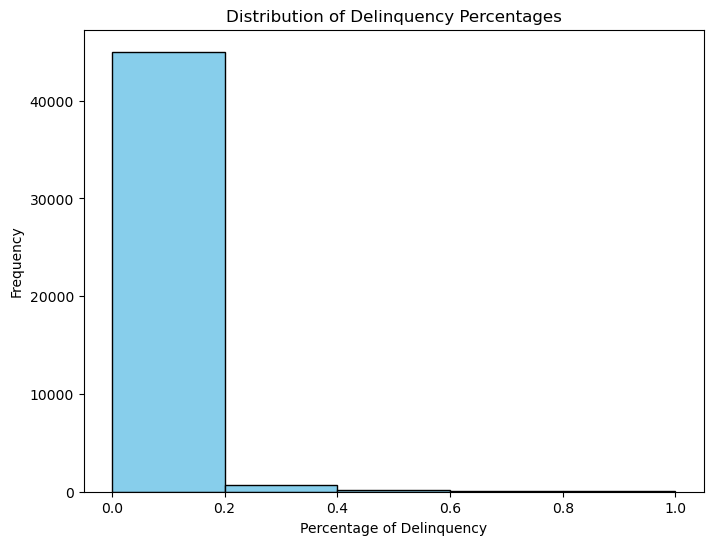

In [16]:
# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(customer_sum['DLQ_PERCENT'], bins=5, edgecolor='black', color='skyblue')
plt.title('Distribution of Delinquency Percentages')
plt.xlabel('Percentage of Delinquency')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Using 15% as the cutoff, check percentage of delinquent customers out of total number of customers
len(customer_sum[customer_sum['DLQ_PERCENT'] >= 0.15]) / len(customer_sum)

0.029792323583777317

3% seem in line with research.
> According to recent data from the Federal Reserve, the delinquency rate on consumer loans at commercial banks in the US is currently around 2.75%. This means that approximately 2.75% of all consumer loans at commercial banks are considered delinquent.

In [18]:
# Create RISK_FLAG column. If NUM_OF_MONTHS <= 2, no flag. Account is too young.
# If account has more than 2 months on record and DLQ_PERCENT >= 0.15, RISK_FLAG should be 1.

# Define conditions list
conditions = [
    (customer_sum['NUM_OF_MONTHS'] <= 2), # should be 0
    (customer_sum['NUM_OF_MONTHS'] > 2) & (customer_sum['DLQ_PERCENT'] >= 0.15)] # should be 1

# Define choices
choices = [0,1]

# Create column using np.select. Everything not matching above conditions will be labeled 0.
customer_sum['RISK_FLAG'] = np.select(conditions,choices,0)

In [19]:
# Final product
customer_sum.head(15)

,ID,FIRST_MONTH,FINAL_MONTH,NUM_OF_MONTHS,NUM_OF_DLQ_MONTHS,DLQ_PERCENT,RISK_FLAG
0,5001711,-3,0,4,0,0.000000,0
1,5001712,-18,0,19,0,0.000000,0
2,5001713,-21,0,22,0,0.000000,0
3,5001714,-14,0,15,0,0.000000,0
4,5001715,-59,0,60,0,0.000000,0
5,5001717,-21,0,22,0,0.000000,0
6,5001718,-38,0,39,2,0.051282,0
7,5001719,-42,0,43,0,0.000000,0
8,5001720,-35,0,36,7,0.194444,1
9,5001723,-30,0,31,0,0.000000,0


Our target variable is `RISK_FLAG`. All of these engineered features will now be merged with the application data.

### Merging the DataFrames

The original `credit_record.csv` has 45985 unique customers. The `application_record.csv` file has 438557 records. We will merge the DataFrames and drop null values in the columns from `customer_sum` DF.

In [20]:
# Merge app_df + customer_sum DataFrames.
merged_df = pd.merge(app_df,customer_sum,how='left',on='ID')

In [21]:
# Dropp NaN values from the merge
merged_df = merged_df[merged_df['FIRST_MONTH'].notnull()]

In [22]:
# View info on merge
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 0 to 434812
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null  int

In [23]:
# Save new df into csv file
merged_df.to_csv('data/combined_data.csv',index=False)

## Exploratory Analysis